In [35]:
import music21
from tqdm import tqdm
import numpy as np

In [36]:
import json

with open('../data/midi_frequencies.json') as file:
    midi_freq = json.load(file)
    
with open('../data/rhythm_frequencies.json') as file:
    rhythm_freq = json.load(file)

In [54]:
def convert_rhythm_freq_to_prob(rhythm_freq):
    """
    Convert rhythm frequencies to probabilities. The returned rhythm_prob will be a
    dict whose keys are sub-beats, and whose values are lists of 2 lists. The first
    list contains the durations (rhythms), and the second list contains the corresponding
    probabilities. Two lists are necessary in order to later use np.random.choice().
    """
    rhythm_prob = {}
    for beat, durations in rhythm_freq.items():
        duration_list = []
        freq_list = []
        
        for duration, freq in durations.items():
            duration_list.append(float(duration))
            freq_list.append(freq)
            
        prob_list = (freq_list / np.sum(freq_list)).tolist()
        rhythm_prob[float(beat)] = [duration_list, prob_list]
        
    return rhythm_prob

In [57]:
def convert_midi_freq_to_prob(midi_freq, lowest_midi, highest_midi):    
    """
    Convert MIDI frequencies to probabilities. The returned midi_prob will be a
    dict whose keys are the previous MIDI note, and whose values are lists of 2 lists.
    The first list contains the next MIDI notes, and the second list contains the corresponding
    probabilities. Two lists are necessary in order to later use np.random.choice().
    """
    midi_prob = {}
    for prev_midi in range(lowest_midi, highest_midi + 1):
        midi_list = []
        freq_list = []
        
        for next_midi in range(lowest_midi, highest_midi + 1):
            midi_list.append(next_midi)
            freq_list.append(midi_freq[prev_midi][next_midi])
        
        prob_list = (freq_list / np.sum(freq_list)).tolist()
        midi_prob[prev_midi] = [midi_list, prob_list]
    
    return midi_prob

In [ ]:
midi_prob = convert_midi_freq_to_prob(midi_freq, 55, 91)
print(midi_prob)

In [55]:
rhythm_prob = convert_rhythm_freq_to_prob(rhythm_freq)
print(rhythm_prob)

{0.0: [[1.0, 1.5, 0.5, 0.25, 0.75, 3.0, 2.0, 4.0, 3.5, 1.75], [0.38201162151812323, 0.031601205441134844, 0.38917100947370176, 0.0824828091440369, 0.022410549274903848, 0.020129534972777675, 0.06275286791761708, 0.00862456502555735, 4.994921829473369e-05, 0.0007658880138525832]], 0.5: [[0.5, 1.0, 0.25, 1.5, 2.0, 0.75, 3.0], [0.6744161093029079, 0.07303551629171287, 0.24060231052612754, 0.0035766658321113058, 0.002503666082477914, 0.005829965306341428, 3.576665832111306e-05]], 0.75: [[0.25, 0.5, 1.0], [0.8287711814195995, 0.1702808389619623, 0.0009479796184382036]], 0.25: [[0.25, 0.5, 0.75, 1.0], [0.7514365457231982, 0.2199967164669184, 0.02364143818748974, 0.004925299622393696]]}


In [77]:
def generate_music(midi_prob, rhythm_prob, key, piece_duration):
    piece = music21.stream.Stream()
    prev_note = music21.note.Note('C5', quarterLength=1)
    piece.append(prev_note)
    cur_beat = prev_note.quarterLength
    
    while cur_beat < piece_duration:
        prev_midi = prev_note.pitch.midi
        cur_midi = np.random.choice(midi_prob[prev_midi][0], p=midi_prob[prev_midi][1])
        cur_note = music21.note.Note(midi=cur_midi)
        piece.append(cur_note)
        
        cur_sub_beat = cur_beat % 1.0
        cur_duration = np.random.choice(rhythm_prob[cur_sub_beat][0], p=rhythm_prob[cur_sub_beat][1])
        cur_note.quarterLength = cur_duration
        cur_beat += cur_duration
    
    return piece

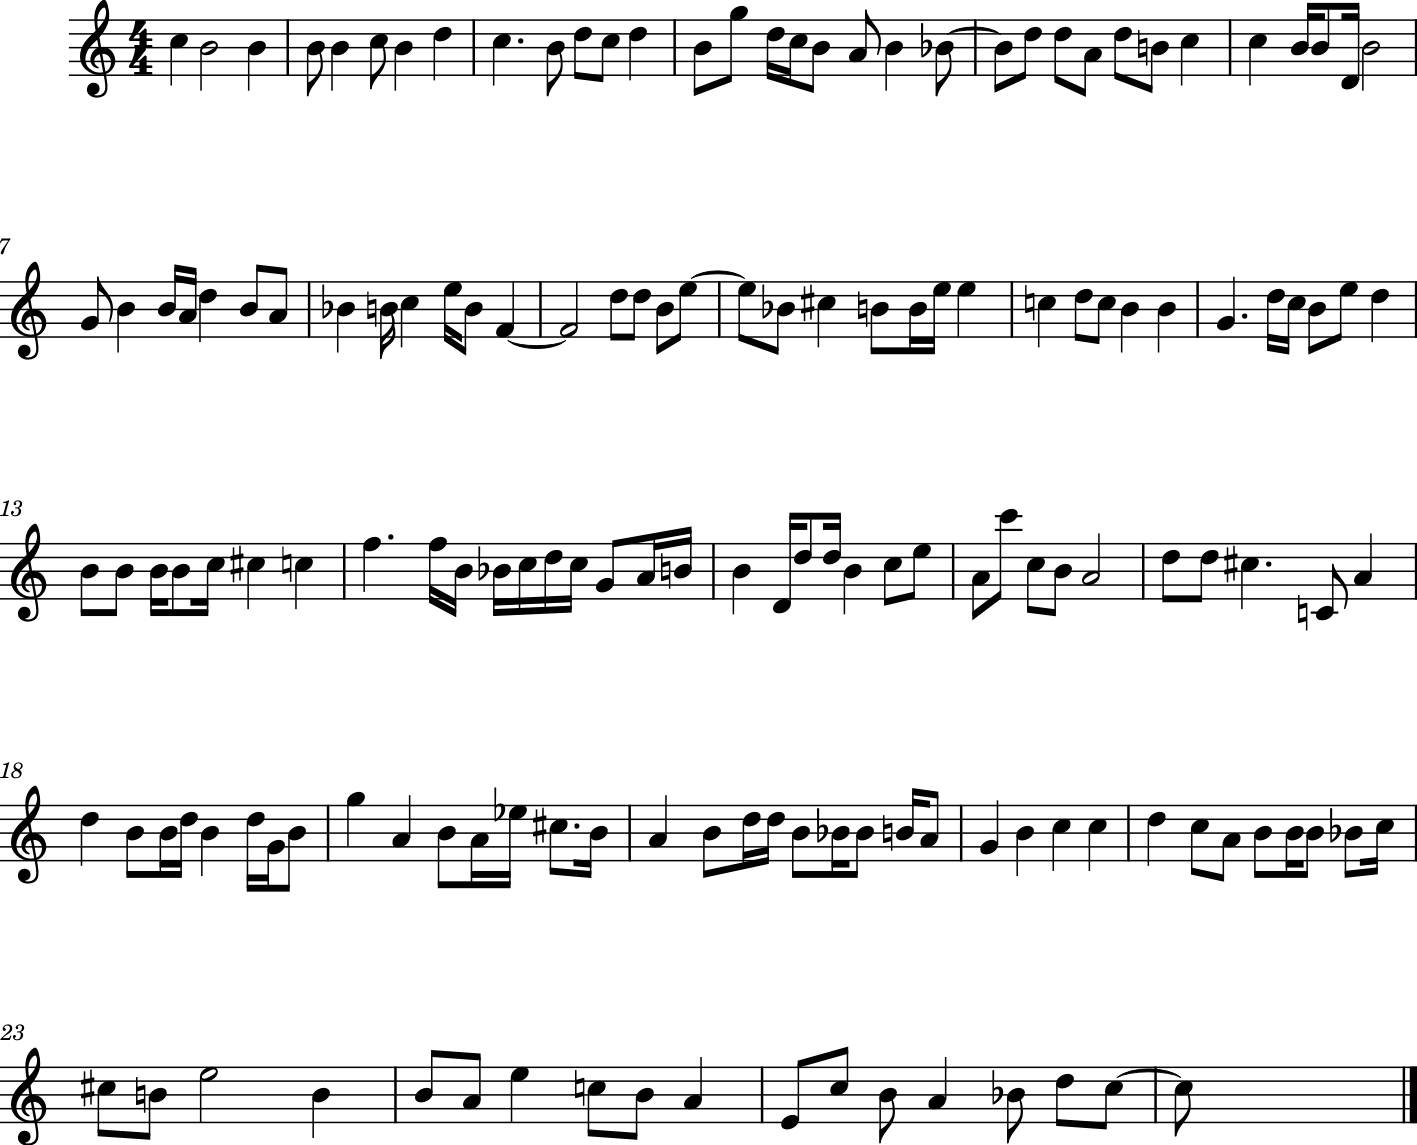

In [80]:
piece = generate_music(midi_prob, rhythm_prob, 'C', 100)
piece.show()

In [79]:
piece.write('musicxml', fp='../composition_001')

WindowsPath('C:/Users/chenc/OneDrive/Desktop/CS 109 Challenge/cs109-challenge/composition_001.musicxml')